## Import

In [147]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
from pathlib import Path
import math
import random
import librosa.display
import shutil

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

In [4]:
#load csvs from previous notebooks

df_seg0=pd.read_csv('df_seg0.csv')
df_seg1=pd.read_csv('df_seg1.csv')
df_seg2=pd.read_csv('df_seg2.csv')

In [70]:
df_seg2=pd.read_csv('df_seg2.csv')

In [14]:
mfcc_names=['mfcc_'+str(x) for x in range(1,14)]
spec_names = ["Spectral_Centroid","Spectral_Rolloff","Spectral_Spread","Spectral_Skewness","Spectral_Kurtosis","Spectral_Bandwidth"]
total_features=mfcc_names+spec_names+['zcr','rms']

In [17]:
df_seg0.columns

Index(['uuid', 'cough_detected', 'status', 'x', 'fs', 'target_binary',
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'Spectral_Centroid', 'Spectral_Rolloff', 'Spectral_Spread',
       'Spectral_Skewness', 'Spectral_Kurtosis', 'Spectral_Bandwidth', 'zcr',
       'rms'],
      dtype='object')

## Model - No Segmentation

In [2]:
#try different classification models on the dataframe with no segmentation

In [48]:
#basline

df_seg0.target_binary.value_counts(normalize=True)

0    0.522867
1    0.477133
Name: target_binary, dtype: float64

In [15]:
X=df_seg0[total_features]

In [18]:
y=df_seg0.target_binary

In [19]:
scaler=StandardScaler()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [21]:
X_train=scaler.fit_transform(X_train)

In [22]:
X_test=scaler.transform(X_test)

#### Logisitic Regression

In [23]:
model=LogisticRegression(max_iter=100000)

In [24]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

In [25]:
print('train:',model.score(X_train,y_train))
print('test:',model.score(X_test,y_test))
print('cv:',cross_val_score(model,X_train,y_train,cv=5).mean())

train: 0.5955631399317406
test: 0.5733788395904437
cv: 0.562291325695581


##### GridSearch

In [26]:
param_grid={'C':np.logspace(-2,0,10),
          'l1_ratio': [0.0001,0.1,0.5,0.7,0.9],
            'penalty':['elasticnet'],
            'solver':['saga']
           }

In [27]:
gs=GridSearchCV(model,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

In [28]:
gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

train: 0.5921501706484642
test: 0.5631399317406144
cv: 0.5861829423531552


In [29]:
gs.best_params_

{'C': 0.016681005372000592,
 'l1_ratio': 0.5,
 'penalty': 'elasticnet',
 'solver': 'saga'}

#### Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
d=DecisionTreeClassifier()


In [32]:
d.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [37]:
param_grid={'max_depth':[14,15,16,17,18],
            'max_leaf_nodes': [10,15,20,30,40,50,60,70,80],
            'criterion': ['gini','entropy']}

In [38]:
gs=GridSearchCV(d,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

In [39]:
gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

train: 0.6510238907849829
test: 0.5563139931740614
cv: 0.5631460265502819


In [40]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 17, 'max_leaf_nodes': 20}

#### KNN

In [41]:
knn=KNeighborsClassifier()

param_grid={'n_neighbors':[5,6,7,8,9,10],
            'weights':['uniform', 'distance'],
            'metric':['cosine','euclidean','manhatten'],
           }

gs=GridSearchCV(knn,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('params:',gs.best_params_)
print('cv:',gs.best_score_)

train: 0.6621160409556314
test: 0.5460750853242321
params: {'metric': 'cosine', 'n_neighbors': 8, 'weights': 'uniform'}
cv: 0.5571449354428077


/Users/christian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.53923259 0.54179305 0.54605565 0.55033279 0.55201673 0.55116567
 0.55714494 0.55034734 0.54516821 0.54004728 0.5477214  0.55202764
 0.51705765 0.51876341 0.52555374 0.54350973 0.53665394 0.5366503
 0.54517912 0.54177487 0.52558647 0.5272886  0.53668667 0.53494454
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  category=UserWarning


#### SVM

In [42]:
svc=SVC(max_iter=100000)

In [43]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 100000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
param_grid={'C':np.logspace(0,1,10),
           'gamma':np.logspace(-3,0,10),
            'kernel':['rbf','sigmoid']
           }

In [45]:
gs = GridSearchCV(svc,
                  param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-2
                  )

In [46]:
gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))

print('test:',gs.score(X_test,y_test))

print('params:',gs.best_params_)

print('cv:',gs.best_score_)

train: 0.5861774744027304
test: 0.5426621160409556
params: {'C': 1.6681005372000588, 'gamma': 0.0021544346900318843, 'kernel': 'rbf'}
cv: 0.5810474631751228


## Model - Coarse Segmentation

In [49]:
X=df_seg1[total_features]
y=df_seg1.target_binary

scaler=StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#### Logisitic Regression

In [50]:
model=LogisticRegression(max_iter=100000)

In [51]:
model.fit(X_train,y_train)
print('train:',model.score(X_train,y_train))
print('test:',model.score(X_test,y_test))
print('cv:',cross_val_score(model,X_train,y_train,cv=5).mean())

train: 0.5808383233532934
test: 0.5824468085106383
cv: 0.5655419262469528


##### GridSearch

In [52]:
param_grid={'C':np.logspace(-3,0,10),
          'l1_ratio': [0.0001,0.1,0.5,0.8,0.9,1],
            'penalty':['l2','l1'],
            'penalty':['elasticnet'],
            'solver':['saga']
           }

In [53]:
gs=GridSearchCV(model,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

In [54]:
gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

train: 0.5818363273453094
test: 0.5664893617021277
cv: 0.5718614048568


In [55]:
gs.best_params_

{'C': 0.046415888336127774,
 'l1_ratio': 0.8,
 'penalty': 'elasticnet',
 'solver': 'saga'}

#### Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
d=DecisionTreeClassifier()


In [58]:
d.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [59]:
param_grid={'max_depth':[11,12,13,14,15],
            'max_leaf_nodes': [10,15,20,30,40,50,60],
            'criterion': ['gini','entropy']}

In [60]:
gs=GridSearchCV(d,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

In [61]:
gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

train: 0.6796407185628742
test: 0.5279255319148937
cv: 0.5582080806629041


In [62]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 11, 'max_leaf_nodes': 40}

#### KNN

In [63]:
knn=KNeighborsClassifier()

param_grid={'n_neighbors':[5,6,7,8,9,10],
            'weights':['uniform', 'distance'],
            'metric':['cosine'],
           }

gs=GridSearchCV(knn,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('params:',gs.best_params_)
print('cv:',gs.best_score_)

train: 1.0
test: 0.714095744680851
params: {'metric': 'cosine', 'n_neighbors': 6, 'weights': 'distance'}
cv: 0.6526929093813743


In [64]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### SVM

In [65]:
svc=SVC(max_iter=100000)

In [66]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 100000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [67]:
param_grid={'C':np.logspace(0,1,10),
           'gamma':np.logspace(-1,0,10),
            'kernel':['rbf']
           }

In [68]:
gs = GridSearchCV(svc,
                  param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-2
                  )

In [69]:
gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))

print('test:',gs.score(X_test,y_test))

print('params:',gs.best_params_)

print('cv:',gs.best_score_)

train: 0.9863606121091151
test: 0.6968085106382979
params: {'C': 2.7825594022071245, 'gamma': 0.21544346900318834, 'kernel': 'rbf'}
cv: 0.6620085018877728


## Model - Fine Segmentation

#### Scale & split

In [74]:
X=df_seg2[total_features]
y=df_seg2.target_binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#### Logistic Regression

In [75]:
model=LogisticRegression(max_iter=100000)

In [76]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

In [77]:
print('train:',model.score(X_train,y_train))
print('test:',model.score(X_test,y_test))
print('cv:',cross_val_score(model,X_train,y_train,cv=5).mean())

train: 0.5849615156897573
test: 0.5621301775147929
cv: 0.5707578347578348


#### GridSearch

In [78]:
param_grid={'C':np.logspace(-2,0,10),
          'l1_ratio': [0.0001,0.1,0.5,0.7,0.9],
            'penalty':['elasticnet'],
            'solver':['saga']
           }

In [79]:
gs=GridSearchCV(model,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

In [80]:
gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

train: 0.581409117821196
test: 0.565680473372781
cv: 0.5719447731755424


In [81]:
gs.best_params_

{'C': 0.0774263682681127,
 'l1_ratio': 0.1,
 'penalty': 'elasticnet',
 'solver': 'saga'}

#### Decision Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [83]:
d=DecisionTreeClassifier()
d.fit(X_train,y_train)

DecisionTreeClassifier()

In [84]:
print('train:',d.score(X_train,y_train))
print('test:',d.score(X_test,y_test))

train: 1.0
test: 0.5431952662721894


In [85]:
d.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### Gridsearch

In [86]:
param_grid={'max_depth':[8,9,10,11,12,13,14],
            'max_leaf_nodes': [60,70,80,90,100],
            'criterion': ['gini','entropy']}

In [87]:
d=DecisionTreeClassifier()

gs=GridSearchCV(d,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

In [88]:
gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

train: 0.7169923031379515
test: 0.5609467455621302
cv: 0.5565399956169188


In [89]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 11, 'max_leaf_nodes': 100}

#### KNN

In [90]:
knn=KNeighborsClassifier()

param_grid={'n_neighbors':[5,6,7,8,9,10],
            'weights':['uniform', 'distance'],
            'metric':['cosine'],
           }

gs=GridSearchCV(knn,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('params:',gs.best_params_)
print('cv:',gs.best_score_)

train: 1.0
test: 0.6757396449704142
params: {'metric': 'cosine', 'n_neighbors': 6, 'weights': 'distance'}
cv: 0.6734788516326978


### SVM

In [91]:
svc=LinearSVC(max_iter=1000000)

In [92]:
svc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [93]:
param_grid={'C':np.logspace(-2,4,10),
           'loss':['hinge'],
           }

In [94]:
gs_lin = GridSearchCV(svc,
                      param_grid,
                      scoring='accuracy',
                      cv=5
                      )

In [ ]:
gs_lin.fit(X_train,y_train)

print('train:',gs_lin.score(X_train,y_train))

print('test:',gs_lin.score(X_test,y_test))

print('params:',gs_lin.best_params_)

print('cv:',gs_lin.best_score_)

#### rbf 

In [96]:
svc=SVC(max_iter=100000)

In [100]:
param_grid={'C':np.logspace(0,1,10),
           'gamma':np.logspace(-1,0,10),
            'kernel':['rbf']
           }

gs = GridSearchCV(svc,
                  param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-2
                  )

gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))

print('test:',gs.score(X_test,y_test))

print('params:',gs.best_params_)

print('cv:',gs.best_score_)

train: 0.9857904085257548
test: 0.6781065088757396
params: {'C': 5.994842503189409, 'gamma': 0.16681005372000587, 'kernel': 'rbf'}
cv: 0.6796901161516546


In [101]:
df_confusion = pd.crosstab(y_test, gs.predict(X_test), rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,289,141,430
1,131,284,415
All,420,425,845


In [102]:
print(classification_report(y_test, gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       430
           1       0.67      0.68      0.68       415

    accuracy                           0.68       845
   macro avg       0.68      0.68      0.68       845
weighted avg       0.68      0.68      0.68       845



### poly

In [103]:
svc=SVC(max_iter=100000,kernel='poly')

In [104]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': 100000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [105]:
param_grid = {'C': np.logspace(-1, 2, 5),
              'gamma': np.logspace(-3, 1, 5),
              'degree': [1, 2, 3,4,5]
              }

In [106]:
gs = GridSearchCV(svc,
                  param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-2
                  )

In [107]:
gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))

print('test:',gs.score(X_test,y_test))

print('params:',gs.best_params_)

print('cv:',gs.best_score_)

train: 0.9357608052101836
test: 0.6366863905325444
params: {'C': 0.5623413251903491, 'degree': 5, 'gamma': 0.1}
cv: 0.6343957922419461


In [108]:
df_confusion = pd.crosstab(y_test, gs.predict(X_test), rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,269,161,430
1,146,269,415
All,415,430,845


In [109]:
print(classification_report(y_test, gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       430
           1       0.63      0.65      0.64       415

    accuracy                           0.64       845
   macro avg       0.64      0.64      0.64       845
weighted avg       0.64      0.64      0.64       845



## Find optimum Level of MFCCs

In [110]:
df_seg2_40mfcc=pd.read_csv('df_seg2_40mfcc.csv')



In [124]:
#KNN
output_list=[]

for n in range(10, 41):

    # create n mfcc

    mfcc_names = ['mfcc_'+str(x) for x in range(1, n+1)]
    
    # model
    
    X=df_seg2_40mfcc[spec_names+mfcc_names+['zcr','rms']]
    y=df_seg2_40mfcc.target_binary

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

    scaler=StandardScaler()

    X_train=scaler.fit_transform(X_train)

    X_test=scaler.transform(X_test)
    
    knn=KNeighborsClassifier()

    param_grid={'n_neighbors':[5,6,7,8,9,10],
                'weights':['uniform', 'distance'],
                'metric':['cosine'],
               }

    gs=GridSearchCV(knn,
                   param_grid,
                   scoring='accuracy',
                   cv=5,
                   n_jobs=-2)

  

    gs.fit(X_train, y_train)

    output = {'n_mfcc': n,
              'train_score': gs.score(X_train, y_train),
              'test_score': gs.score(X_test, y_test),
              'best_params': gs.best_params_,
              'cv:': gs.best_score_}
    
    output_list.append(output)
    

In [125]:
df_n_mfcc=pd.DataFrame(output_list)

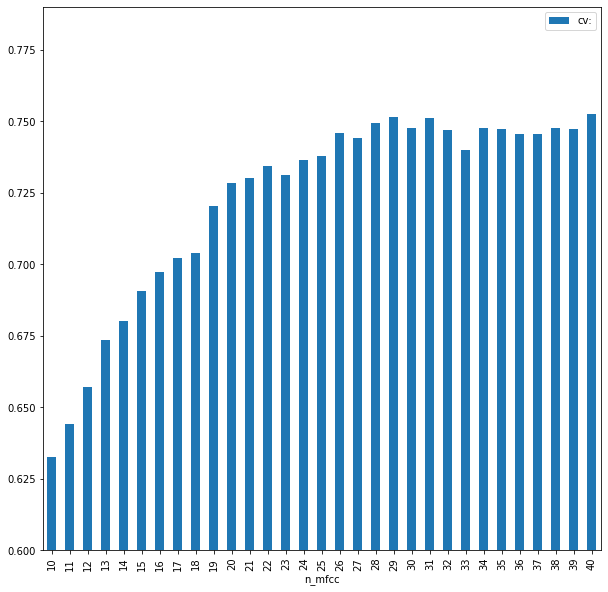

In [126]:
df_n_mfcc.plot(x='n_mfcc',y='cv:',kind='bar',figsize=(10,10))
plt.ylim(0.6)
plt.show()

In [131]:
df_n_mfcc.sort_values('cv:',ascending=False)

,n_mfcc,train_score,test_score,best_params,cv:
30,40,1.0,0.769231,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.752514
19,29,1.0,0.756213,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.751629
21,31,1.0,0.773964,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.751038
18,28,1.0,0.762130,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.749556
24,34,1.0,0.782249,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.747780
20,30,1.0,0.753846,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.747777
28,38,1.0,0.775148,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.747777
25,35,1.0,0.775148,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.747192
29,39,1.0,0.776331,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.747189
22,32,1.0,0.768047,"{'metric': 'cosine', 'n_neighbors': 6, 'weight...",0.746888


### Remodel with 40 MFCC

In [143]:
total_features_2=total_features+['mfcc_'+str(x) for x in range(14, 41)]

In [144]:
X=df_seg2_40mfcc[total_features_2]
y=df_seg2_40mfcc.target_binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)



### SVM Poly

In [ ]:
svc=SVC(max_iter=100000,kernel='poly')

param_grid = {'C': np.logspace(-1, 3, 10),
              'gamma': np.logspace(-3, 1, 10),
              'degree': [3,4,5,6]
              }

gs = GridSearchCV(svc,
                  param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-2
                  )

gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('params:',gs.best_params_)
print('cv:',gs.best_score_)

### KNN

In [136]:
knn=KNeighborsClassifier()

param_grid={'n_neighbors':[5,6,7,8,9,10],
            'weights':['uniform', 'distance'],
            'metric':['cosine'],
           }

gs=GridSearchCV(knn,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('params:',gs.best_params_)
print('cv:',gs.best_score_)

train: 1.0
test: 0.7692307692307693
params: {'metric': 'cosine', 'n_neighbors': 6, 'weights': 'distance'}
cv: 0.7525141354372122


### Logisitic Regression

In [145]:
model=LogisticRegression(max_iter=100000)
param_grid={'C':np.logspace(-2,0,10),
          'l1_ratio': [0.0001,0.1,0.5,0.7,0.9],
            'penalty':['elasticnet'],
            'solver':['saga']
           }

gs=GridSearchCV(model,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)


train: 0.5899940793368857
test: 0.6071005917159763
cv: 0.5689765505150121


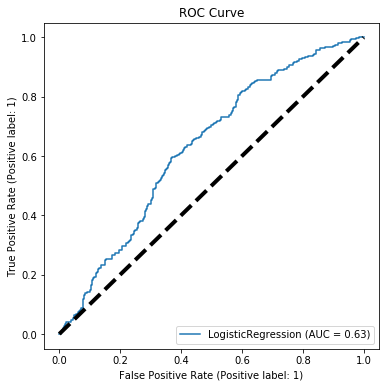

In [148]:
#Plotting ROC Curve

fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(gs.best_estimator_, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
ax.set_title('ROC Curve')
plt.show()

### Decision Tree

In [127]:
d=DecisionTreeClassifier()


param_grid={'max_depth':[14,15,16],
            'max_leaf_nodes': [10,15,20,30,40,50,60,70,80],
            'criterion': ['gini','entropy']}

gs=GridSearchCV(d,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

print('params:',gs.best_params_)

train: 0.668651200985424
test: 0.5591133004926109
cv: 0.5662056547148949
params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 50}


### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf= RandomForestClassifier(n_estimators=100)

In [55]:
param_grid={}

gs=GridSearchCV(rf,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

print('params:',gs.best_params_)

train: 1.0
test: 0.7093596059113301
cv: 0.681377560153741
params: {}


### SVM

In [137]:
svc = SVC(max_iter=100000)

param_grid = {'C': np.logspace(0, 2, 5),
              'gamma': np.logspace(-3, 1, 5),
              'kernel': ['rbf']
              }

gs = GridSearchCV(svc,
                  param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-2,
                  verbose=1
                  )

gs.fit(X_train, y_train)

print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('cv:',gs.best_score_)

print('params:',gs.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
train: 1.0
test: 0.7715976331360946
cv: 0.729121630506246
params: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}


## Bagging

In [138]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier

In [139]:
X=df_seg2_40mfcc[total_features_2]
y=df_seg2_40mfcc.target_binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#### Bag KNN

In [140]:
knn=KNeighborsClassifier()

param_grid={'n_neighbors':[5,6,7],
            'weights':['uniform', 'distance'],
            'metric':['cosine'],
           }

gs=GridSearchCV(knn,
               param_grid,
               scoring='accuracy',
               cv=5,
               n_jobs=-2)

gs.fit(X_train,y_train)

print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('params:',gs.best_params_)
print('cv:',gs.best_score_)

train: 1.0
test: 0.7727810650887574
params: {'metric': 'cosine', 'n_neighbors': 6, 'weights': 'distance'}
cv: 0.7554770984001753


In [141]:
knn=KNeighborsClassifier()

BC = BaggingClassifier(base_estimator=knn)

params_bag = {'base_estimator__n_neighbors': [2,3],
              'n_estimators': [100],
              'base_estimator__metric': ['cosine'],
              'base_estimator__weights':['distance']
              }

# Fitting the Bag
gs = GridSearchCV(BC,
                      params_bag,
                      n_jobs=-2,
                      cv=5,
                      verbose=1)

In [142]:
gs.fit(X_train,y_train)
print('train:',gs.score(X_train,y_train))
print('test:',gs.score(X_test,y_test))
print('params:',gs.best_params_)
print('cv:',gs.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
train: 1.0
test: 0.8047337278106509
params: {'base_estimator__metric': 'cosine', 'base_estimator__n_neighbors': 2, 'base_estimator__weights': 'distance', 'n_estimators': 100}
cv: 0.7838952443567828


In [69]:
predictions=gs.predict(X_test)

In [71]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       640
           1       0.86      0.84      0.85       578

    accuracy                           0.86      1218
   macro avg       0.86      0.86      0.86      1218
weighted avg       0.86      0.86      0.86      1218



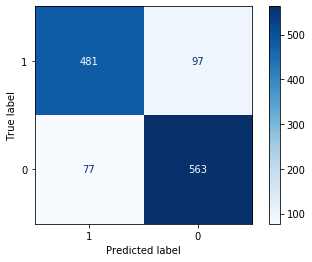

In [136]:
plot_confusion_matrix(gs.best_estimator_,X_test,y_test,labels=[1, 0],cmap=plt.cm.Blues)
plt.show()

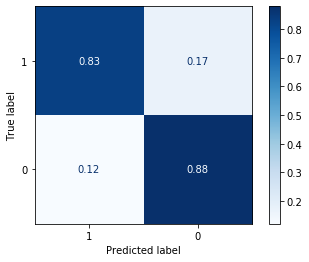

In [137]:
plot_confusion_matrix(gs.best_estimator_,X_test,y_test,labels=[1, 0],cmap=plt.cm.Blues,normalize='true')
plt.show()

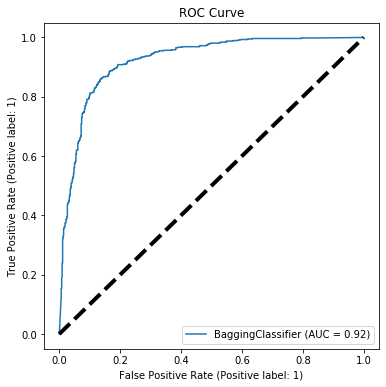

In [129]:
#Plotting ROC Curve

fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(gs.best_estimator_, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
ax.set_title('ROC Curve')
plt.show()

In [130]:
roc_auc_score(y_test, gs.best_estimator_.predict_proba(X_test)[:, 1])

0.9230793144463668

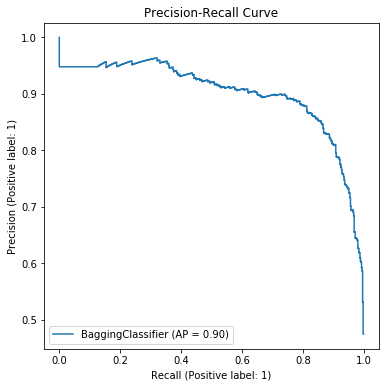

In [131]:
# Plot of a precision-recall curve for class 1
plt.fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(gs.best_estimator_, X_test, y_test, ax=ax)
ax.set_title('Precision-Recall Curve')
plt.show()

In [132]:
average_precision_score(y_test, gs.best_estimator_.predict_proba(X_test)[:, 1])

0.9001262492672617